# Facies classification using machine learning techniques

### ISPL Team
##### Contact author: <a href="https://home.deib.polimi.it/bestagini/">Paolo Bestagini</a>

In the following, we provide a possible solution to the facies classification problem described at https://github.com/seg/2016-ml-contest.

This is a corrected version of [our previous submission try03](https://github.com/seg/2016-ml-contest/blob/master/ispl/facies_classification_try03.ipynb) built upon:
- Part of the feature engineering work presented in [our previous submission](https://github.com/seg/2016-ml-contest/blob/master/ispl/facies_classification_try02.ipynb).
- The gradient boosting classifier used in [SHandPR submission](https://github.com/seg/2016-ml-contest/blob/master/SHandPR/Face_classification_SHPR_GradientBoost.ipynb).


## Script initialization
Let us import the used packages and define some parameters (e.g., colors, labels, etc.).

In [1]:
# Import
from __future__ import division
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20.0, 10.0)
inline_rc = dict(mpl.rcParams)
from classification_utilities import make_facies_log_plot

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import LeavePGroupsOut
from sklearn.metrics import f1_score
from sklearn.multiclass import OneVsOneClassifier
from sklearn.ensemble import GradientBoostingClassifier

from scipy.signal import medfilt

In [2]:
import sys, scipy, sklearn
print('Python:  ' + sys.version.split('\n')[0])
print('         ' + sys.version.split('\n')[1])
print('Pandas:  ' + pd.__version__)
print('Numpy:   ' + np.__version__)
print('Scipy:   ' + scipy.__version__)
print('Sklearn: ' + sklearn.__version__)

Python:  3.5.2 |Continuum Analytics, Inc.| (default, Jul  2 2016, 17:52:12) 
         [GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]
Pandas:  0.18.1
Numpy:   1.11.2
Scipy:   0.18.1
Sklearn: 0.18


In [3]:
# Parameters
feature_names = ['GR', 'ILD_log10', 'DeltaPHI', 'PHIND', 'PE', 'NM_M', 'RELPOS']
facies_names = ['SS', 'CSiS', 'FSiS', 'SiSh', 'MS', 'WS', 'D', 'PS', 'BS']
facies_colors = ['#F4D03F', '#F5B041','#DC7633','#6E2C00', '#1B4F72','#2E86C1', '#AED6F1', '#A569BD', '#196F3D']

## Load data
Let us load training data and store features, labels and other data into numpy arrays.

In [4]:
# Load data from file
data = pd.read_csv('../facies_vectors.csv')

In [5]:
# Store features and labels
X = data[feature_names].values  # features
y = data['Facies'].values  # labels

In [6]:
# Store well labels and depths
well = data['Well Name'].values
depth = data['Depth'].values

In [7]:
# Sort data according to depth for each well
for w_idx, w in enumerate(np.unique(well)):
    X_well = X[well == w]
    X[well == w] = X_well[np.argsort(depth[well == w])]
    depth[well == w] = np.sort(depth[well == w])

## Data inspection
Let us inspect the features we are working with. This step is useful to understand how to normalize them and how to devise a correct cross-validation strategy. Specifically, it is possible to observe that:
- Some features seem to be affected by a few outlier measurements.
- Only a few wells contain samples from all classes.
- PE measurements are available only for some wells.

In [8]:
# Define function for plotting feature statistics
def plot_feature_stats(X, y, feature_names, facies_colors, facies_names):
    
    # Remove NaN
    nan_idx = np.any(np.isnan(X), axis=1)
    X = X[np.logical_not(nan_idx), :]
    y = y[np.logical_not(nan_idx)]
    
    # Merge features and labels into a single DataFrame
    features = pd.DataFrame(X, columns=feature_names)
    labels = pd.DataFrame(y, columns=['Facies'])
    for f_idx, facies in enumerate(facies_names):
        labels[labels[:] == f_idx] = facies
    data = pd.concat((labels, features), axis=1)

    # Plot features statistics
    facies_color_map = {}
    for ind, label in enumerate(facies_names):
        facies_color_map[label] = facies_colors[ind]

    sns.pairplot(data, hue='Facies', palette=facies_color_map, hue_order=list(reversed(facies_names)))

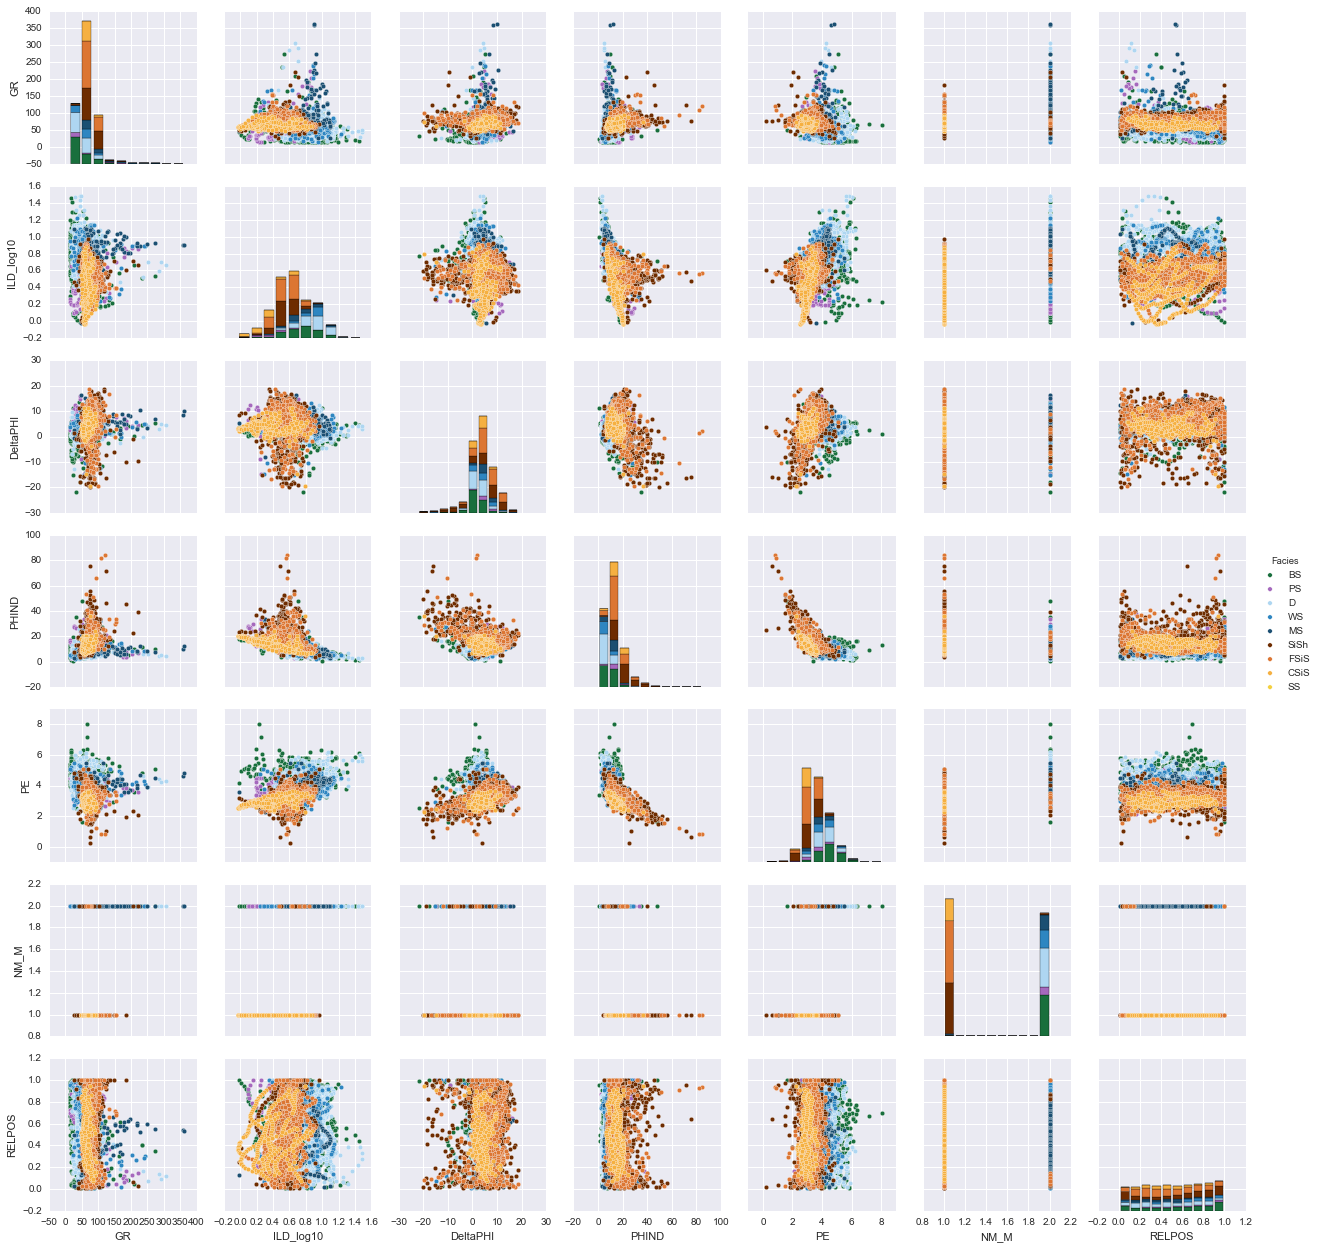

In [9]:
# Feature distribution
plot_feature_stats(X, y, feature_names, facies_colors, facies_names)
mpl.rcParams.update(inline_rc)

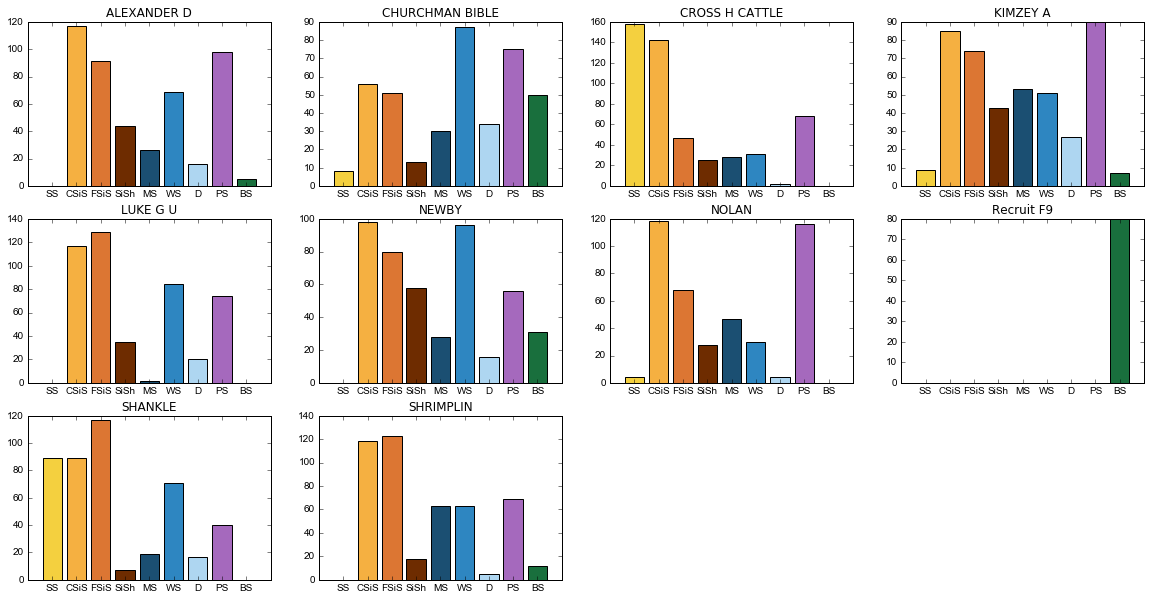

In [10]:
# Facies per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.histogram(y[well == w], bins=np.arange(len(facies_names)+1)+.5)
    plt.bar(np.arange(len(hist[0])), hist[0], color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist[0])))
    ax.set_xticklabels(facies_names)
    ax.set_title(w)

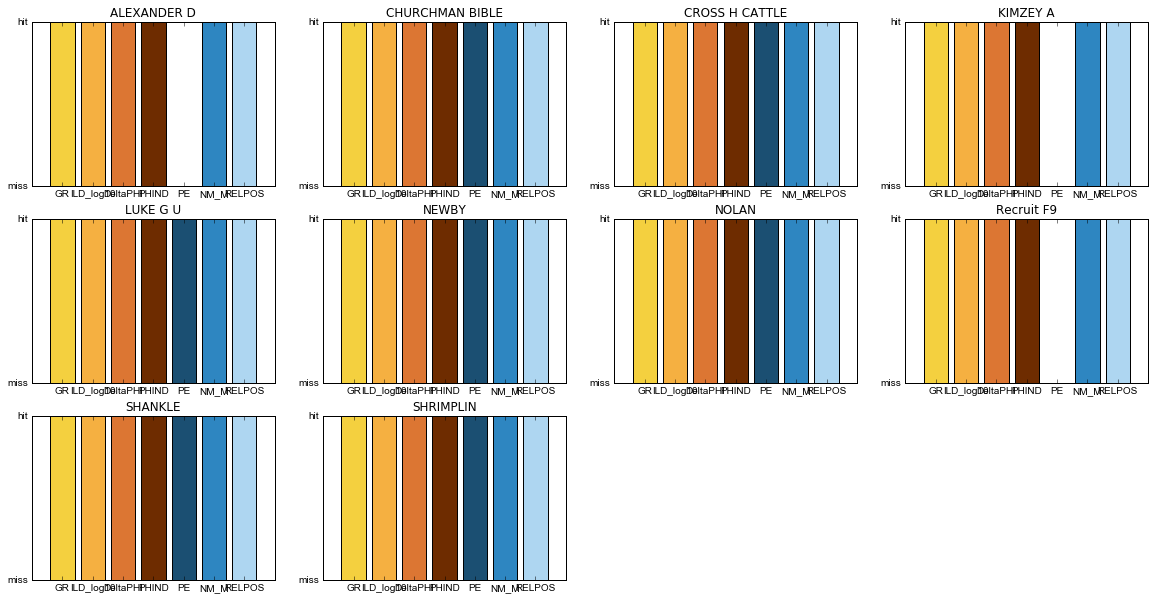

In [11]:
# Features per well
for w_idx, w in enumerate(np.unique(well)):
    ax = plt.subplot(3, 4, w_idx+1)
    hist = np.logical_not(np.any(np.isnan(X[well == w, :]), axis=0))
    plt.bar(np.arange(len(hist)), hist, color=facies_colors, align='center')
    ax.set_xticks(np.arange(len(hist)))
    ax.set_xticklabels(feature_names)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['miss', 'hit'])
    ax.set_title(w)

## Feature imputation
Let us fill missing PE values. Different strategies could be used. We simply substitute them with the average PE value.

In [12]:
imp = preprocessing.Imputer(missing_values='NaN', strategy='mean', axis=0)
imp.fit(X)
X = imp.transform(X)

## Feature augmentation
In this submission, we propose a feature augmentation strategy based on:
- Computing feature spatial gradient.
- Computing higher order features and interaction terms.

In [13]:
# Feature gradient computation function
def augment_features_gradient(X, depth):
    
    # Compute features gradient
    d_diff = np.diff(depth).reshape((-1, 1))
    d_diff[d_diff==0] = 0.001
    X_diff = np.diff(X, axis=0)
    X_grad = X_diff / d_diff
        
    # Compensate for last missing value
    X_grad = np.concatenate((X_grad, np.zeros((1, X_grad.shape[1]))))
    
    return X_grad

In [14]:
# Feature augmentation function
def augment_features(X, well, depth):
    
    # Augment features
    padded_rows = []
    X_aug = np.zeros((X.shape[0], X.shape[1]*2))
    for w in np.unique(well):
        w_idx = np.where(well == w)[0]
        X_aug_grad = augment_features_gradient(X[w_idx, :], depth[w_idx])
        X_aug[w_idx, :] = np.concatenate((X[w_idx, :], X_aug_grad), axis=1)
        padded_rows.append(w_idx[-1])
        
    # Find padded rows
    #padded_rows = np.where(~X_aug[:, 7:].any(axis=1))[0]
    
    return X_aug, padded_rows

In [15]:
# Augment features
X_aug, padded_rows = augment_features(X, well, depth)

In [16]:
# Add higher degree terms and interaction terms to the model
deg = 2
poly = preprocessing.PolynomialFeatures(deg, interaction_only=False)
X_aug = poly.fit_transform(X_aug)
X_aug = X_aug[:,1:]

## Generate training, validation and test data splits
The choice of training and validation data is paramount in order to avoid overfitting and find a solution that generalizes well on new data. For this reason, we generate a set of training-validation splits so that:
- Features from each well belongs to training or validation set.
- Training and validation sets contain at least one sample for each class.

In [17]:
# Initialize model selection methods
lpgo = LeavePGroupsOut(2)

# Generate splits
split_list = []
for train, val in lpgo.split(X, y, groups=data['Well Name']):
    hist_tr = np.histogram(y[train], bins=np.arange(len(facies_names)+1)+.5)
    hist_val = np.histogram(y[val], bins=np.arange(len(facies_names)+1)+.5)
    if np.all(hist_tr[0] != 0) & np.all(hist_val[0] != 0):
        split_list.append({'train':train, 'val':val})
            
# Print splits
for s, split in enumerate(split_list):
    print('Split %d' % s)
    print('    training:   %s' % (data['Well Name'][split['train']].unique()))
    print('    validation: %s' % (data['Well Name'][split['val']].unique()))

Split 0
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['ALEXANDER D' 'CHURCHMAN BIBLE']
Split 1
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN' 'Recruit F9' 'NEWBY'
 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'CROSS H CATTLE']
Split 2
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'KIMZEY A']
Split 3
    training:   ['SHRIMPLIN' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'NOLAN']
Split 4
    training:   ['SHRIMPLIN' 'LUKE G U' 'KIMZEY A' 'CROSS H CATTLE' 'NOLAN' 'Recruit F9'
 'NEWBY' 'CHURCHMAN BIBLE']
    validation: ['ALEXANDER D' 'SHANKLE']
Split 5
    training:   ['SHRIMPLIN' 'ALEXANDER D' 'SHANKLE' 'LUKE G U' 'KIMZEY A' 'NOLAN'
 'Recruit F9' 'NEWBY']
    validation: ['CROSS H CATTLE' 'CHURCHMAN BIBLE'

## Classification parameters optimization
Let us perform the following steps for each set of parameters:
- Select a data split.
- Normalize features using a robust scaler.
- Train the classifier on training data.
- Test the trained classifier on validation data.
- Repeat for all splits and average the F1 scores.

At the end of the loop, we select the classifier that maximizes the average F1 score on the validation set. Hopefully, this classifier should be able to generalize well on new data.

In [18]:
# # Parameters search grid (uncomment parameters for full grid search... may take a lot of time)
# Loss_grid = ['exponential'] # ['deviance', 'exponential']
# N_grid = [100] # [100]
# M_grid = [10] # [5, 10, 15]
# S_grid = [25] # [10, 25, 50, 75]
# L_grid = [5] # [2, 3, 4, 5, 10, 25]
# R_grid = [.1] # [.05, .1, .5]
# Sub_grid = [1] # [0.5, 0.75, 1]
# MED_grid = [1] # [0, 1]
# param_grid = []
# for N in N_grid:
#     for M in M_grid:
#         for S in S_grid:
#             for L in L_grid:
#                 for R in R_grid:
#                     for Sub in Sub_grid:
#                         for MED in MED_grid:
#                             for Loss in Loss_grid:
#                                 param_grid.append({'N':N, 'M':M, 'S':S, 'L':L,
#                                                    'R':R, 'Sub':Sub, 'MED': MED, 'Loss':Loss})

In [29]:
# Train and test a classifier
def train_and_test(X_tr, y_tr, X_v, well_v, clf):
    
    # Feature normalization
    scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0)).fit(X_tr)
    X_tr = scaler.transform(X_tr)
    X_v = scaler.transform(X_v)
    
    clf.fit(X_tr, y_tr)
    
    # Test classifier
    y_v_hat = clf.predict(X_v)
    
    # Clean isolated facies for each well
    if param['MED']:
        for w in np.unique(well_v):
            y_v_hat[well_v==w] = medfilt(y_v_hat[well_v==w], kernel_size=5)
    
    return y_v_hat

In [20]:
# For each set of parameters
# score_param = []
# for param in param_grid:
    
#     # For each data split
#     score_split = []
#     for split in split_list:
    
#         # Remove padded rows
#         split_train_no_pad = np.setdiff1d(split['train'], padded_rows)
        
#         # Select training and validation data from current split
#         X_tr = X_aug[split_train_no_pad, :]
#         X_v = X_aug[split['val'], :]
#         y_tr = y[split_train_no_pad]
#         y_v = y[split['val']]
        
#         # Select well labels for validation data
#         well_v = well[split['val']]

#         # Train and test
#         y_v_hat = train_and_test(X_tr, y_tr, X_v, well_v, param)
        
#         # Score
#         score = f1_score(y_v, y_v_hat, average='micro')
#         score_split.append(score)

#     # Average score for this param
#     score_param.append(np.mean(score_split))
          
# # Best set of parameters
# best_idx = np.argmax(score_param)
# param_best = param_grid[best_idx]
# score_best = score_param[best_idx]
# print('\nBest F1 score = %.3f %s' % (score_best, param_best))


Best F1 score = 0.564 {'MED': 1, 'S': 25, 'R': 0.1, 'Sub': 1, 'Loss': 'exponential', 'M': 10, 'L': 5, 'N': 100}


## Predict labels on test data
Let us now apply the selected classification technique to test data.

In [24]:
# Best params from team's optimization
param = {'MED': 1, 'S': 25, 'R': 0.1, 'Sub': 1, 'Loss': 'exponential', 'M': 10, 'L': 5, 'N': 100}

In [23]:
# Load data from file
test_data = pd.read_csv('../validation_data_nofacies.csv')

In [22]:
# # Prepare training data
# X_tr = X
# y_tr = y

# # Augment features
# X_tr, padded_rows = augment_features(X_tr, well, depth)

# # Removed padded rows
# X_tr = np.delete(X_tr, padded_rows, axis=0)
# y_tr = np.delete(y_tr, padded_rows, axis=0)

In [25]:
# Prepare test data
well_ts = test_data['Well Name'].values
depth_ts = test_data['Depth'].values
X_ts = test_data[feature_names].values

In [26]:
# Sort data according to depth for each well
for w_idx, w in enumerate(np.unique(well_ts)):
    X_ts_well = X_ts[well_ts == w]
    X_ts[well_ts == w] = X_ts_well[np.argsort(depth_ts[well_ts == w])]
    depth_ts[well_ts == w] = np.sort(depth_ts[well_ts == w])

# Augment features
# X_ts, padded_rows = augment_features(X_ts, well_ts, depth_ts)

In [31]:
y_pred = []
print('.' * 100)
for seed in range(100):
    np.random.seed(seed)

    # Make training data.
    X_train, padded_rows = augment_features(X, well, depth)
    y_train = y
    X_train = np.delete(X_train, padded_rows, axis=0)
    y_train = np.delete(y_train, padded_rows, axis=0) 

    # Train classifier
    clf = OneVsOneClassifier(GradientBoostingClassifier(loss=param['Loss'],
                                        n_estimators=param['N'],
                                        learning_rate=param['R'], 
                                        max_features=param['M'],
                                        min_samples_leaf=param['L'],
                                        min_samples_split=param['S'],
                                        random_state=seed,
                                        subsample=param['Sub'],
                                        max_leaf_nodes=None, 
                                        verbose=0), n_jobs=-1)

    # Make blind data.
    X_test, _ = augment_features(X_ts, well_ts, depth_ts)

    # Train and test.
    y_ts_hat = train_and_test(X_train, y_train, X_test, well_ts, clf)
    
    # Collect result.
    y_pred.append(y_ts_hat)
    print('|', end='')
    
np.save('ispl_100_realizations.npy', y_pred)

....................................................................................................
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||

In [24]:
# Predict test labels
# y_ts_hat = train_and_test(X_tr, y_tr, X_ts, well_ts, param_best)

In [25]:
# Save predicted labels
# test_data['Facies'] = y_ts_hat
# test_data.to_csv('well_data_with_facies_try03_v2.csv')

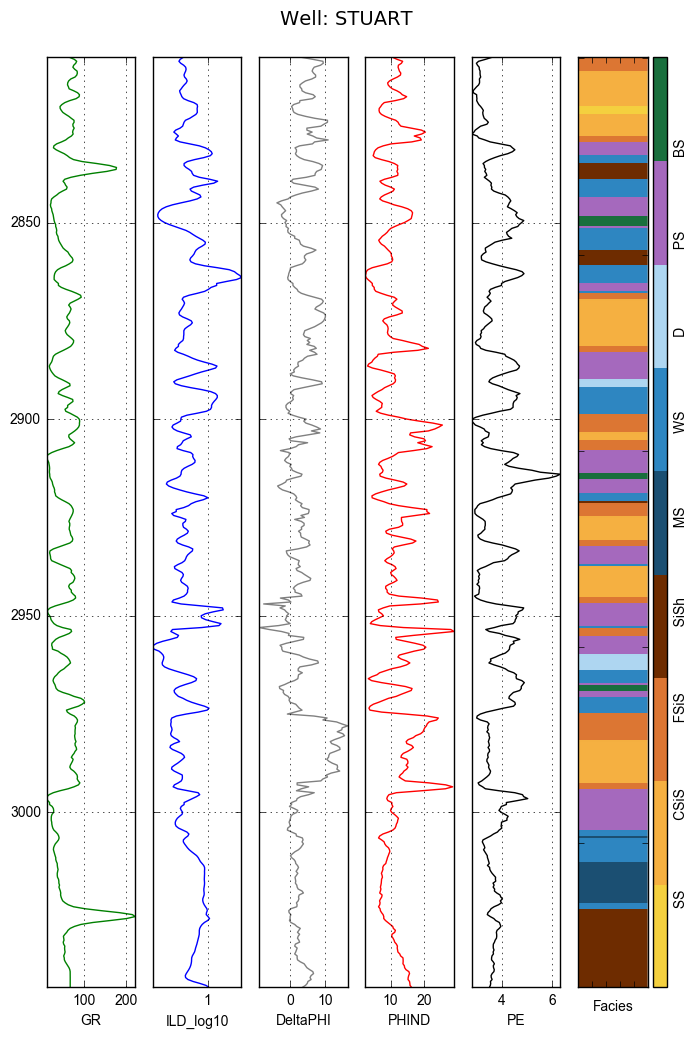

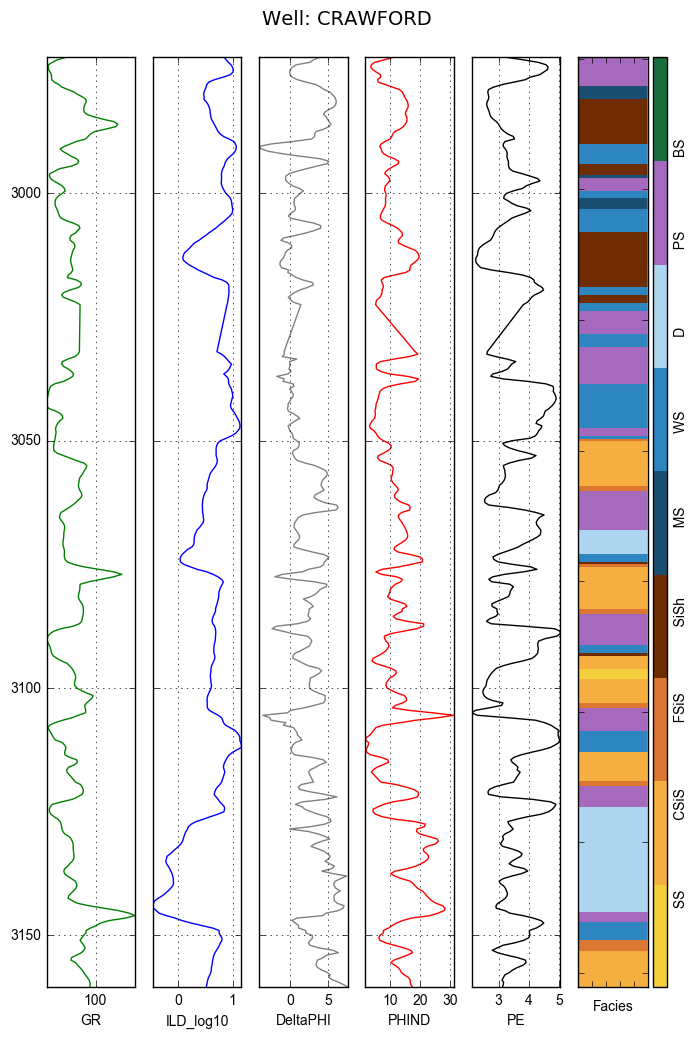

In [26]:
# Plot predicted labels
make_facies_log_plot(
    test_data[test_data['Well Name'] == 'STUART'],
    facies_colors=facies_colors)

make_facies_log_plot(
    test_data[test_data['Well Name'] == 'CRAWFORD'],
    facies_colors=facies_colors)
mpl.rcParams.update(inline_rc)